#### **Welcome to Assignment 2 on Deep Learning for Computer Vision.**
This assignment consists of three parts. Part-1 is based on the content you learned in Week-3 of course and Part-2 is based on the content you learned in Week-4 of the course. Part-3 is **un-graded** and mainly designed to help you flex the Deep Learning muscles grown in Part-2. 

Unlike the first two parts, you'll have to implement everything from scratch in Part-3. If you find answers to questions in Part-3, feel free to head out to the forums and discuss them with your classmates!

#### **Instructions**
1. Use Python 3.x to run this notebook
2. Write your code only in between the lines 'YOUR CODE STARTS HERE' and 'YOUR CODE ENDS HERE'.
you sould not change anything else code cells, if you do, the answers you are supposed to get at the end of this assignment might be wrong.
3. Read documentation of each function carefully.
4. All the Best!

# Part-1

In [ ]:
# Imports
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image

# %matplotlib inline uncomment this line if you're running this notebook on your local PC

In [ ]:
# DO NOT CHANGE THIS CODE
np.random.seed(10)

### Question 1 : Line detection from a given image.


Find the starting and ending point co-ordinates of detected lines of a given image using hough transform. 

Following criterion need to be satisfied to qualify as a line:

(a) Minimum line length = 60;
(b) Maximum allowed gap between line segments = 250;
(c) Accumulator threshold parameter = 15  (only those lines are returned that get enough votes);
(d) Distance resolution of the accumulator in pixels = 1;
(e) Angle resolution of the accumulator in radians = pi/180


Which of the following pairs of (start, end) co-ordinates of detected lines are true:

1. line-1: (1,81), (27,9) ; line-2 : (92,0), (95,64)
2. line-1: (2,79), (26,11) ; line-2 : (92,1), (94,67)
3. line-1: (2,80), (26,10) ; line-2: (91,2), (96,65)
4.  None of the above

# Solution to Question 1

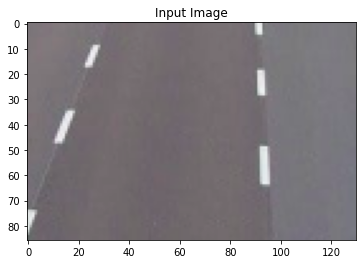

start and end coordinates:  (0, 83) (25, 9)
start and end coordinates:  (92, 0) (95, 64)
start and end coordinates:  (1, 81) (27, 9)
start and end coordinates:  (90, 0) (92, 63)


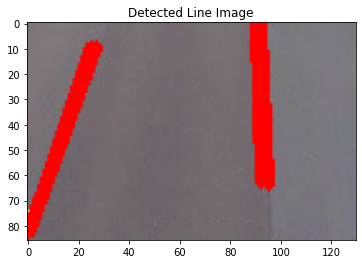

In [ ]:
#Read image 
img = cv2.imread('line.png', cv2.IMREAD_COLOR)

# Visualize the input image
plt.imshow(img)
plt.title('Input Image')
plt.show()


#convert the image to gray-scale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

#Find the edges in the image using canny detector

edges = cv2.Canny(gray, 50, 200)

####YOUR CODE STARTS HERE #####

#Detect points that forms a line
lines = cv2.HoughLinesP(edges, 1, np.pi/180, 15, minLineLength=60,maxLineGap=250)

#Draw lines on the image
for line in lines:
    x1,y1,x2,y2 = line[0]
    print ("start and end coordinates: ", (x1,y1),(x2,y2) )
    cv2.line(img, (x1,y1), (x2,y2), (255,0,0), 3)

####YOUR CODE ENDS HERE #####
plt.imshow(img)
plt.title('Detected Line Image')
plt.show()

##Question 2: Point matching using RANSAC

Given two sets of points related by affine transformation(with an outlier rate), use the RANSAC method to estimate the Affine transformation parameters between them and the number of inliers(Matching points).

Which of the following is the estimated number of inliers for an outlier rate of 0.9:

1. 89
2. 101
3. 117
4. 132

# Solution to Question 2

In [ ]:
import numpy as np
np.random.seed(0)


# Affine Transform
# |x'|  = |a, b| * |x|  +  |tx|
# |y'|    |c, d|   |y|     |ty|
# pts_t =    A   * pts_s  + t

# -------------------------------------------------------------
# Test Class Affine

class Affine_Transform():

    def create_test_case(self, outlier_rate=0):
        ''' CREATE_TEST_CASE

            Randomly generate a test case of affine transformation.

            Input arguments:

            - outlier_rate : the percentage of outliers in test case,
            default is 0

            Outputs:

            - pts_s : Source points that will be transformed
            - pts_t : warped points
            - A, t : parameters of affine transformation, A is a 2x2
            matrix, t is a 2x1 vector, both of them are created randomly

        '''

        # Randomly generate affine transformation
        # A is a 2x2 matrix, the range of each value is from -2 to 2
        A = 4 * np.random.rand(2, 2) - 2

        # % t is a 2x1 VECTOR, the range of each value is from -10 to 10
        t = 20 * np.random.rand(2, 1) - 10

        # Set the number of points in test case
        num = 1000

        # Compute the number of outliers and inliers respectively
        outliers = int(np.round(num * outlier_rate))
        inliers = int(num - outliers)

        # Gernerate source points whose scope from (0,0) to (100, 100)
        pts_s = 100 * np.random.rand(2, num)
        # Initialize warped points matrix
        pts_t = np.zeros((2, num))

        # Compute inliers in warped points matrix by applying A and t
        pts_t[:, :inliers] = np.dot(A, pts_s[:, :inliers]) + t

        # Generate outliers in warped points matrix
        pts_t[:, inliers:] = 100 * np.random.rand(2, outliers)

        # Reset the order of warped points matrix,
        # outliers and inliers will scatter randomly in test case
        rnd_idx = np.random.permutation(num)
        pts_s = pts_s[:, rnd_idx]
        pts_t = pts_t[:, rnd_idx]

        return A, t, pts_s, pts_t

    def estimate_affine(self, pts_s, pts_t):
        ''' ESTIMATE_AFFINE

            Estimate affine transformation by the given points
            correspondences.

            Input arguments:
            - pts_t : points in target image
            - pts_s : points in source image

            Outputs:

            - A, t : the affine transformation, A is a 2x2 matrix
            that indicates the rotation and scaling transformation,
            t is a 2x1 vector determines the translation

            Method:

            To estimate an affine transformation between two images,
            at least 3 corresponding points are needed.
            In this case, 6-parameter affine transformation are taken into
            consideration, which is shown as follows:

            | x' | = | a b | * | x | + | tx |
            | y' |   | c d |   | y |   | ty |

            For 3 corresponding points, 6 equations can be formed as below:

            | x1 y1 0  0  1 0 |       | a  |       | x1' |
            | 0  0  x1 y1 0 1 |       | b  |       | y1' |
            | x2 y2 0  0  1 0 |   *   | c  |   =   | x2' |
            | 0  0  x2 y2 0 1 |       | d  |       | y2' |
            | x3 y3 0  0  1 0 |       | tx |       | x3' |
            | 0  0  x3 y3 0 1 |       | ty |       | y3' |

            |------> M <------|   |-> theta <-|   |-> b <-|

            Solve the equation to compute theta by:  theta = M \ b
            Thus, affine transformation can be obtained as:

            A = | a b |     t = | tx |
                | c d |         | ty |

        '''

        # Get the number of corresponding points
        pts_num = pts_s.shape[1]

        # Initialize the matrix M,
        # M has 6 columns, since the affine transformation
        # has 6 parameters in this case
        M = np.zeros((2 * pts_num, 6))

        for i in range(pts_num):
            # Form the matrix m
            temp = [[pts_s[0, i], pts_s[1, i], 0, 0, 1, 0],
                    [0, 0, pts_s[0, i], pts_s[1, i], 0, 1]]
            M[2 * i: 2 * i + 2, :] = np.array(temp)

        # Form the matrix b,
        # b contains all known target points
        b = pts_t.T.reshape((2 * pts_num, 1))

        try:
            # Solve the linear equation
            theta = np.linalg.lstsq(M, b)[0]

            # Form the affine transformation
            A = theta[:4].reshape((2, 2))
            t = theta[4:]
        except np.linalg.linalg.LinAlgError:
            # If M is singular matrix, return None
            # print("Singular matrix.")
            A = None
            t = None

        return A, t
# -------------------------------------------------------------

# Create instance
af = Affine_Transform()

# Generate a test case as validation with
# a rate of outliers
outlier_rate = 0.90
A_true, t_true, pts_s, pts_t = af.create_test_case(outlier_rate)

# At least 3 corresponding points to
# estimate affine transformation
K = 3
# Randomly select 3 pairs of points to do estimation
idx = np.random.randint(0, pts_s.shape[1], (K, 1))

A_test, t_test = af.estimate_affine(pts_s[:, idx], pts_t[:, idx])

# Display known parameters with estimations
# They should be same when outlier_rate equals to 0,
# otherwise, they are totally different in some cases
#print(A_true, '\n', t_true)
#print(A_test, '\n', t_test)

# -------------------------------------------------------------
# Test Class Ransac
# The number of iterations in RANSAC
ITER_NUM = 2000


class Ransac():

    def __init__(self, K=3, threshold=1):
        ''' __INIT__

            Initialize the instance.

            Input argements:

            - K : the number of corresponding points,
            default is 3
            - threshold : determing which points are inliers
            by comparing residual with it

        '''

        self.K = K
        self.threshold = threshold

    def residual_lengths(self, A, t, pts_s, pts_t):
        ''' RESIDUAL_LENGTHS

            Compute residual length (Euclidean distance) between
            estimation and real target points. Estimation are
            calculated by the given source point and affine
            transformation (A & t).

            Input arguments:

            - A, t : the estimated affine transformation calculated
            by least squares method
            - pts_s : key points from source image
            - pts_t : key points from target image

            Output:

            - residual : Euclidean distance between estimated points
            and real target points

        '''

        if not(A is None) and not(t is None):
            # Calculate estimated points:
            # pts_e = A * pts_s + t
            pts_e = np.dot(A, pts_s) + t

            # Calculate the residual length between estimated points
            # and target points
            diff_square = np.power(pts_e - pts_t, 2)
            residual = np.sqrt(np.sum(diff_square, axis=0))
        else:
            residual = None

        return residual

    def ransac_fit(self, pts_s, pts_t):
        ''' RANSAC_FIT

            Apply the method of RANSAC to obtain the estimation of
            affine transformation and inliers as well.

            Input arguments:

            - pts_s : key points from source image
            - pts_t : key points from target image

            Output:

            - A, t : estimated affine transformation
            - inliers : indices of inliers that will be applied to refine the
            affine transformation

        '''
        #### YOUR CODE START HERE
        # Create a Affine instance to do estimation
        af = Affine_Transform()

        # Initialize the number of inliers
        inliers_num = 0

        # Initialize the affine transformation A and t,
        # and a vector that stores indices of inliers
        A = None
        t = None
        inliers = None

        for i in range(ITER_NUM):
            # Randomly generate indices of points correspondences
            idx = np.random.randint(0, pts_s.shape[1], (self.K, 1))
            # Estimate affine transformation by these points
            A_tmp, t_tmp = af.estimate_affine(pts_s[:, idx], pts_t[:, idx])

            # Calculate the residual by applying estimated transformation
            residual = self.residual_lengths(A_tmp, t_tmp, pts_s, pts_t)

            if not(residual is None):
                # Obtain the indices of inliers
                inliers_tmp = np.where(residual < self.threshold)
                # Obtain the number of inliers
                inliers_num_tmp = len(inliers_tmp[0])

                # Set affine transformation and indices of inliers
                # in one iteration which has the most of inliers
                if inliers_num_tmp > inliers_num:
                    # Update the number of inliers
                    inliers_num = inliers_num_tmp
                    # Set returned value
                    inliers = inliers_tmp
                    A = A_tmp
                    t = t_tmp
            else:
                pass
        ### YOUR CODE ENDS HERE
        return A, t, inliers
# -------------------------------------------------------------

# Create instance
rs = Ransac(K=3, threshold=1)

residual = rs.residual_lengths(A_test, t_test, pts_s, pts_t)

# Run RANSAC to estimate affine transformation when
# too many outliers in points set
A_rsc, t_rsc, inliers = rs.ransac_fit(pts_s, pts_t)
#print(A_rsc, '\n', t_rsc)
# print the number of inliners or point matches
print (inliers[0].shape)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:132: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


(101,)


### Question 3: Detect corners in a given image using Harris Corner Detection Algorithm

Find the number of detected corner points in a given image using Harris Corner Detection Algorithm. Note that, Following criterion MUST be satisfied while applying Harris Corner detection Algorithm:

(a)  The size of neighbourhood considered for corner detection = 2.
(b)  Aperture parameter of Sobel derivative used = 3.
(c)  Harris detector free parameter in the equation = 0.04.

which of the following are true?

1.   169
2.   222
3.   264
4.   309


# Solution to Question 3

Number of Detected Corners:  222


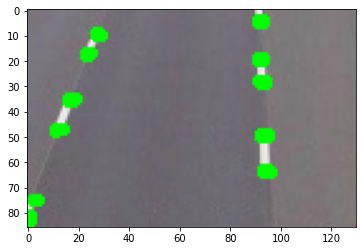

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

%matplotlib inline

# Read in the image
image = cv2.imread('line.png')

# Make a copy of the image
image_copy = np.copy(image)

# Change color to RGB (from BGR)
image_copy = cv2.cvtColor(image_copy, cv2.COLOR_BGR2RGB)

###YOUR CODE STARTS HERE

## STEP 1:  Convert to grayscale 
gray_img = cv2.cvtColor(image_copy, cv2.COLOR_RGB2GRAY)
gray_img = np.float32(gray_img)

## STEP 2: Detect corners 
dilst = cv2.cornerHarris(gray_img, 2, 3, 0.04)

## STEP 3: Dilate corner image to enhance corner points
dilst = cv2.dilate(dilst,None)

plt.imshow(dilst, cmap='gray')


## STEP 4:set threshold value as 0.1 * (maximum value of dilated corner image obtained from STEP3)
thresh = 0.1 * dilst.max()

#STEP 5: Count numer of detected corner points and draw them on the image
# Create an image copy to draw corners on
corner_image = np.copy(image_copy)

# Iterate through all the corners and draw them on the image (if they pass the threshold)
count = 0
for j in range(0, dilst.shape[0]):
    for i in range(0, dilst.shape[1]):
        if(dilst[j,i] > thresh):
            count += 1
            cv2.circle( corner_image, (i, j), 1, (0,255,0), 1)

print ("Number of Detected Corners: ", count)
plt.imshow(corner_image)

### YOUR CODE ENDS HERE

# Part-2

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import torch.nn.functional as F
import timeit
import unittest

## Please DONOT remove these lines. 
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(0)

### Data Loading and Pre-processing

In [ ]:
# check availability of GPU and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define a set of transforms for preparing the dataset
transform = transforms.Compose([
        transforms.ToTensor(), # convert the image to a pytorch tensor
        transforms.Normalize((0.1307,), (0.3081,)) # normalise the images with mean and std of the dataset
        ])

In [ ]:
# Load the MNIST training, test datasets using `torchvision.datasets.MNIST`
#### YOUR CODE STARTS HERE ####
train_dataset = datasets.MNIST('./data', train=True, download=True,
                       transform=transform)
test_dataset = datasets.MNIST('../data', train=False, download=True,
                       transform=transform)
#### YOUR CODE ENDS HERE ####

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!




/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!


In [ ]:
# create dataloaders for training and test datasets
# use a batch size of 32 and set shuffle=True for the training set
#### YOUR CODE STARTS HERE ####
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32)
#### YOUR CODE ENDS HERE ####

### Network Definition

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #### YOUR CODE STARTS HERE ####
        # define a conv layer with output channels as 16, kernel size of 3 and stride of 1
        self.conv1 = nn.Conv2d(1, 16, 3, 1)
        # define a conv layer with output channels as 32, kernel size of 3 and stride of 1
        self.conv2 = nn.Conv2d(16, 32, 3, 1)
        # define a conv layer with output channels as 64, kernel size of 3 and stride of 1
        self.conv3 = nn.Conv2d(32, 64, 3, 1)
        # define a max pooling layer with kernel size 2
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        # define dropout layer with a probability of 0.25
        self.dropout1 = nn.Dropout2d(0.25)
        # define dropout layer with a probability of 0.5
        self.dropout2 = nn.Dropout2d(0.5)
        # define a linear(dense) layer with 128 output features
        self.fc1 = nn.Linear(7744, 128)
        # define a linear(dense) layer with output features corresponding to the number of classes in the dataset
        self.fc2 = nn.Linear(128, 10)
        #### YOUR CODE ENDS HERE ####

    def forward(self, x):
        # Use the layers defined above in a sequential way (folow the same as the layer definitions above) and 
        # write the forward pass, after each of conv1, conv2, conv3 and fc1 use a relu activation. 
        #### YOUR CODE STARTS HERE ####
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.maxpool(x)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        #### YOUR CODE ENDS HERE ####
        output = F.log_softmax(x, dim=1)
        return output

### Sanity Check
Make sure all the tests below pass without any errors, before you proceed with the training part.

In [ ]:
import unittest

class TestImplementations(unittest.TestCase):
    
    # Dataloading tests
    def test_dataset(self):
        self.dataset_classes = ['0 - zero',
                                '1 - one',
                                '2 - two',
                                '3 - three',
                                '4 - four',
                                '5 - five',
                                '6 - six',
                                '7 - seven',
                                '8 - eight',
                                '9 - nine']
        self.assertTrue(train_dataset.classes == self.dataset_classes)
        self.assertTrue(train_dataset.train == True)
    
    def test_dataloader(self):        
        self.assertTrue(train_dataloader.batch_size == 32)
        self.assertTrue(test_dataloader.batch_size == 32)      
         
    def test_total_parameters(self):
        model = Net().to(device)
        self.assertTrue(sum(p.numel() for p in model.parameters()) == 1015946)

suite = unittest.TestLoader().loadTestsFromModule(TestImplementations())
unittest.TextTestRunner().run(suite)

...
----------------------------------------------------------------------
Ran 3 tests in 8.293s

OK


<unittest.runner.TextTestResult run=3 errors=0 failures=0>

### Training and Inference

In [ ]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
      #### YOUR CODE STARTS HERE ####
        # send the image, target to the device
        data, target = data.to(device), target.to(device)
        # flush out the gradients stored in optimizer
        optimizer.zero_grad()
        # pass the image to the model and assign the output to variable named output
        output = model(data)
        # calculate the loss (use nll_loss in pytorch)
        loss = F.nll_loss(output, target)
        # do a backward pass
        loss.backward()
        # update the weights
        optimizer.step()
      #### YOUR CODE ENDS HERE ####
        if batch_idx % 20 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [ ]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
          ### YOUR CODE STARTS HERE ####
            # send the image, target to the device
            data, target = data.to(device), target.to(device)
            # pass the image to the model and assign the output to variable named output
            output = model(data)
          #### YOUR CODE ENDS HERE ####
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

### Question 4

Run the code cell below and report the final test accuracy (If you are not getting the exact number shown in options, please report the closest number).
1. 64%
2. 79%
3. 97%
4. 90%

In [ ]:
model = Net().to(device)

## Define Adam Optimiser with a learning rate of 0.01
optimizer = optim.Adam(model.parameters(), lr=0.01)

start = timeit.default_timer()
for epoch in range(1, 11):
    train(model, device, train_dataloader, optimizer, epoch)
    test(model, device, test_dataloader)
stop = timeit.default_timer()
print('Total time taken: {} seconds'.format(int(stop - start)) )

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.297386
Train Epoch: 1 [640/60000 (1%)]	Loss: 1.521403
Train Epoch: 1 [1280/60000 (2%)]	Loss: 0.624750
Train Epoch: 1 [1920/60000 (3%)]	Loss: 0.433802
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.361034
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.487633
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.549782
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.228510
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.699078
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.525807
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.781974
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.406401
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.129923
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.501867
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.430719
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.723553
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.464335
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.442992
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.281543
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.510889
Train Epoch: 1 [12800/60000 (

### Question 5

Modify the network to replace ReLU activations with Sigmoid and report the final test accuracy by running the cell below. (If you are not getting the exact number shown in options, please report the closest number). 

1. 95%
2. 54%
3. 20%
4. 9%

In [ ]:
class NetSigmoid(nn.Module):
    def __init__(self):
        super(NetSigmoid, self).__init__()
        #### YOUR CODE STARTS HERE ####
        # define a conv layer with output channels as 16, kernel size of 3 and stride of 1
        self.conv1 = nn.Conv2d(1, 16, 3, 1)
        # define a conv layer with output channels as 32, kernel size of 3 and stride of 1
        self.conv2 = nn.Conv2d(16, 32, 3, 1)
        # define a conv layer with output channels as 64, kernel size of 3 and stride of 1
        self.conv3 = nn.Conv2d(32, 64, 3, 1)
        # define dropout layer with a probability of 0.25
        self.dropout1 = nn.Dropout2d(0.25)
        # define dropout layer with a probability of 0.5
        self.dropout2 = nn.Dropout2d(0.5)
        # define a linear(dense) layer with 128 output features
        self.fc1 = nn.Linear(7744, 128)
        # define a linear(dense) layer with output features corresponding to the number of classes in the dataset
        self.fc2 = nn.Linear(128, 10)
        #### YOUR CODE ENDS HERE ####

    def forward(self, x):
        x = self.conv1(x)
        x = torch.sigmoid(x)
        x = self.conv2(x)
        x = torch.sigmoid(x)
        x = self.conv3(x)
        x = torch.sigmoid(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = torch.sigmoid(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [ ]:
model = NetSigmoid().to(device)

## Define Adam Optimiser with a learning rate of 0.01
optimizer = optim.Adam(model.parameters(), lr=0.01)

start = timeit.default_timer()

for epoch in range(1, 11):
    train(model, device, train_dataloader, optimizer, epoch)
    test(model, device, test_dataloader)

stop = timeit.default_timer()
print('Total time taken: {} seconds'.format(int(stop - start)) )

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.417075
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.433431
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.466533
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.268619
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.309747
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.423191
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.494345
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.329737
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.430910
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.370892
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.458553
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.401397
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.460954
Train Epoch: 1 [8320/60000 (14%)]	Loss: 2.444475
Train Epoch: 1 [8960/60000 (15%)]	Loss: 2.322423
Train Epoch: 1 [9600/60000 (16%)]	Loss: 2.518139
Train Epoch: 1 [10240/60000 (17%)]	Loss: 2.397117
Train Epoch: 1 [10880/60000 (18%)]	Loss: 2.351655
Train Epoch: 1 [11520/60000 (19%)]	Loss: 2.404890
Train Epoch: 1 [12160/60000 (20%)]	Loss: 2.402580
Train Epoch: 1 [12800/60000 (

### Question 6

Train the network defined in Question-1 with Adagrad optimizer with the same learning rate mentioned in the question. Report the final test accuracy by running the cell below. (If you are not getting the exact number shown in options, please report the closest number). 

1. 80%
2. 99%
3. 92%
4. 85%

In [ ]:
model = Net().to(device)

## Define Adam Optimiser with a learning rate of 0.01
optimizer = optim.Adagrad(model.parameters(), lr=0.01)

start = timeit.default_timer()

for epoch in range(1, 11):
    train(model, device, train_dataloader, optimizer, epoch)
    test(model, device, test_dataloader)

stop = timeit.default_timer()
print('Total time taken: {} seconds'.format(int(stop - start)) )

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.330998
Train Epoch: 1 [640/60000 (1%)]	Loss: 1.032659
Train Epoch: 1 [1280/60000 (2%)]	Loss: 0.475337
Train Epoch: 1 [1920/60000 (3%)]	Loss: 0.333172
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.562689
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.395132
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.378077
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.339353
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.292866
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.246078
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.317377
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.453168
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.264298
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.212126
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.302641
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.054165
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.123051
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.075083
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.388811
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.376938
Train Epoch: 1 [12800/60000 (

### Question 7

Initialize the `Conv2d` layers in the network defined in Question-1 `(Net)` with all ones (both weights and bias). Train the network with Adam optimizer and report the final test accuracy by running the cell below. (If you are not getting the exact number shown in options, please report the closest number). 

1. 11%
2. 18%
3. 97%
4. 6%

In [ ]:
model = Net().to(device)

def init_weights(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.ones_(m.weight.data)
        torch.nn.init.ones_(m.bias.data)

model.apply(init_weights)  
## Define Adam Optimiser with a learning rate of 0.01
optimizer = optim.Adam(model.parameters(), lr=0.01)

start = timeit.default_timer()

for epoch in range(1, 5):
    train(model, device, train_dataloader, optimizer, epoch)
    test(model, device, test_dataloader)

stop = timeit.default_timer()
print('Total time taken: {} seconds'.format(int(stop - start)) )

Train Epoch: 1 [0/60000 (0%)]	Loss: 257302.312500
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.159845
Train Epoch: 1 [1280/60000 (2%)]	Loss: 4879.193848
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.311894
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.303710
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.302960
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.313120
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.295476
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.283089
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.317263
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.307127
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.300141
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.316991
Train Epoch: 1 [8320/60000 (14%)]	Loss: 2.296788
Train Epoch: 1 [8960/60000 (15%)]	Loss: 2.304055
Train Epoch: 1 [9600/60000 (16%)]	Loss: 2.310983
Train Epoch: 1 [10240/60000 (17%)]	Loss: 2.296943
Train Epoch: 1 [10880/60000 (18%)]	Loss: 2.308717
Train Epoch: 1 [11520/60000 (19%)]	Loss: 2.301711
Train Epoch: 1 [12160/60000 (20%)]	Loss: 2.318455
Train Epoch: 1 [12800

### Question 8

Initialize the network defined in Question-1 `(Net)` with Xavier's initialization ([torch.nn.init.xavier_normal](https://pytorch.org/docs/stable/nn.init.html))(for bias use zero). Train the network with Adam optimizer and report the final test accuracy by running the cell below. (If you are not getting the exact number shown in options, please report the closest number). 


1. 88%
2. 74%
3. 97%
4. 80%

In [ ]:
model = Net().to(device)

def init_weights(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_normal_(m.weight.data)
        torch.nn.init.zeros_(m.bias.data)
        

model.apply(init_weights)  
## Define Adam Optimiser with a learning rate of 0.01
optimizer = optim.Adam(model.parameters(), lr=0.01)

start = timeit.default_timer()

for epoch in range(1, 5):
    train(model, device, train_dataloader, optimizer, epoch)
    test(model, device, test_dataloader)

stop = timeit.default_timer()
print('Total time taken: {} seconds'.format(int(stop - start)) )

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.297024
Train Epoch: 1 [640/60000 (1%)]	Loss: 1.374989
Train Epoch: 1 [1280/60000 (2%)]	Loss: 1.113245
Train Epoch: 1 [1920/60000 (3%)]	Loss: 0.796265
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.923752
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.793446
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.546034
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.577412
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.503001
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.600036
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.298844
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.339188
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.460355
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.224056
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.509679
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.330694
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.413311
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.709194
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.405228
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.599053
Train Epoch: 1 [12800/60000 (

### Question 9

Add three batch-norm layers to the network defined in `Question-1` and report the final test accuracy by running the cell below. 

1. 92%
2. 89%
3. 98%
4. 74%

In [ ]:
class NetBatchNorm(nn.Module):
    def __init__(self):
        super(NetBatchNorm, self).__init__()
        #### YOUR CODE STARTS HERE ####
        # define a conv layer with output channels as 16, kernel size of 3 and stride of 1
        self.conv1 = nn.Conv2d(1, 16, 3, 1)
        # define a batchnorm layer (2d) with 16 features
        self.bn1 = nn.BatchNorm2d(16)
        # define a conv layer with output channels as 32, kernel size of 3 and stride of 1
        self.conv2 = nn.Conv2d(16, 32, 3, 1)
        # define a batchnorm layer (2d) with 32 features
        self.bn2 = nn.BatchNorm2d(32)
        # define a conv layer with output channels as 64, kernel size of 3 and stride of 1
        self.conv3 = nn.Conv2d(32, 64, 3, 1)
        # define a batchnorm layer (2d) with 64 features
        self.bn3 = nn.BatchNorm2d(64)
        # define dropout layer with a probability of 0.25
        self.dropout1 = nn.Dropout2d(0.25)
        # define dropout layer with a probability of 0.5
        self.dropout2 = nn.Dropout2d(0.5)
        # define a linear(dense) layer with 128 output features
        self.fc1 = nn.Linear(7744, 128)
        # self.bn1 = nn.BatchNorm2d(128)
        # define a linear(dense) layer with output features corresponding to the number of classes in the dataset
        self.fc2 = nn.Linear(128, 10)
        #### YOUR CODE ENDS HERE ####

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [ ]:
# If you implemented the batchnorm layers correctly this cell should return true
sum(p.numel() for p in model.parameters()) == 1016170

True

In [ ]:
model = NetBatchNorm().to(device)

## Define Adam Optimiser with a learning rate of 0.01
optimizer = optim.Adam(model.parameters(), lr=0.01)

start = timeit.default_timer()
for epoch in range(1, 11):
    train(model, device, train_dataloader, optimizer, epoch)
    test(model, device, test_dataloader)
stop = timeit.default_timer()
print('Total time taken: {} seconds'.format(int(stop - start)) )

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.454934
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.028876
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.190406
Train Epoch: 1 [1920/60000 (3%)]	Loss: 1.598089
Train Epoch: 1 [2560/60000 (4%)]	Loss: 1.995649
Train Epoch: 1 [3200/60000 (5%)]	Loss: 1.396168
Train Epoch: 1 [3840/60000 (6%)]	Loss: 1.395989
Train Epoch: 1 [4480/60000 (7%)]	Loss: 1.722398
Train Epoch: 1 [5120/60000 (9%)]	Loss: 1.333850
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.229044
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.440405
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.760624
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.561758
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.414709
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.674654
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.031416
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.928298
Train Epoch: 1 [10880/60000 (18%)]	Loss: 2.773321
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.589015
Train Epoch: 1 [12160/60000 (20%)]	Loss: 1.298261
Train Epoch: 1 [12800/60000 (

# Part-3

This section is un-graded and purely for practice. 

Main focus of this part is to help you flex the deep learning muscles built in the above part. You should build a network on the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). This dataset is similar to MNIST but unlike MNIST, the images are colored and more complex. 

As of writing this, the state-of-the-art(SoTA) performance on this dataset is 98.98%. You can try to start with the simple network we defined above for the MNSIT dataset(with some modification for dealing with different sized colored images unlike MNIST). But to achive the SoTA performance you need to do a lot of hackery. These are list of few things, we would encourage you to try: 

- Use data augmentation wisely. Read and understand how to perform the augmentations listed below. 
    * RandomFlips, Color Jittering
    * Cutout, Cutmix
    * Mixup
    * Auto-augment

- Try to increase the image size using standard image interpolation techniques. Try using tricks like Progressive resizing of images and see if it helps. 

- After certain number of layers, adding more layer might not be of much help, run experiments on SVHN and see if you observe this. 

- To understand the difficulties in training deeper networks read this paper: [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385)

- To improve the performance on SVHN, try using architectures like [ResNet](https://arxiv.org/abs/1512.03385), [DesnseNet](https://arxiv.org/abs/1608.06993) or [EfficientNet](https://arxiv.org/abs/1905.11946). Most of these architectures are available by default in PyTorch.
